
# Stroke Prediction — Tech Challenge (Notebook Base)

Este notebook implementa um pipeline completo de *Machine Learning* para o dataset **Stroke Prediction** (Kaggle), cobrindo as etapas propostas pelo professor:

1) **Problema** *(classificação)*  
2) **Coleta** *(Kaggle)*  
3) **Armazenamento** *(CSV, versões e splits)*  
4) **Analisar** *(EDA)*  
5) **Processar** *(limpeza, imputação, codificação, escala)*  
6) **Modelagem** *(baselines, busca de hiperparâmetros, threshold)*  
7) **Deploy** *(artefatos, função de inferência e API opcional)*

> **Avisos importantes:**  
> - Uso **exclusivamente educacional**, não clínico.  
> - Dados **anonimizados**; evitar qualquer tentativa de reidentificação.  
> - Verifique o caminho do arquivo CSV antes de executar.


## 0) Setup e Imports

In [1]:

# (Opcional) instalar dependências caso necessário
# Se o ambiente já tiver os pacotes, você pode pular esta célula.
try:
    import sklearn, imblearn, matplotlib, pandas, numpy, joblib
except Exception:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q",
                           "scikit-learn", "imbalanced-learn", "matplotlib", "pandas", "numpy", "joblib"])

import sys, os, json, time, random, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from datetime import datetime

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    roc_auc_score, average_precision_score, classification_report,
    precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.inspection import permutation_importance

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from scipy.stats import randint

import joblib

# parâmetros gerais
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

# Paths (ajuste conforme sua estrutura)
BASE_DIR = Path(".").resolve()
DATA_DIR = (BASE_DIR / "data")
RAW_PATH = DATA_DIR / "raw"
INTERIM_PATH = DATA_DIR / "interim"
PROC_PATH = DATA_DIR / "processed"
MODELS_PATH = BASE_DIR / "models"

for p in [RAW_PATH, INTERIM_PATH, PROC_PATH, MODELS_PATH]:
    p.mkdir(parents=True, exist_ok=True)

print("Versões:")
print(" - Python:", sys.version.split()[0])
import sklearn, imblearn
print(" - scikit-learn:", sklearn.__version__)
print(" - imbalanced-learn:", imblearn.__version__)
print(" - pandas:", pd.__version__)
print(" - numpy:", np.__version__)
print(" - matplotlib:", plt.matplotlib.__version__)


Versões:
 - Python: 3.13.2
 - scikit-learn: 1.7.2
 - imbalanced-learn: 0.14.0
 - pandas: 2.3.3
 - numpy: 2.3.3
 - matplotlib: 3.10.6



## 1) Definição do Problema

- **Tarefa:** Classificação binária — prever `stroke` (1 = teve AVC, 0 = não).
- **Objetivo:** Estimar o risco de AVC com base em atributos clínicos/demográficos.
- **Métricas foco:** AUC-ROC, **AUC-PR**, *Recall*, *Precision* da classe positiva e **Balanced Accuracy**.
- **Observação:** Classe positiva é **rara** — cuidado com desbalanceamento e threshold.
- **Ética & viés:** Reportar métricas por subgrupos (ex.: `gender`, `Residence_type`).
- **Nota:** `id` é identificador e **não** entra no modelo.


## 2) Coleta e Carregamento de Dados (Kaggle → CSV)

In [2]:

# Informe o nome do arquivo CSV baixado do Kaggle e colocado em data/raw
# Exemplos comuns no Kaggle:
#  - "healthcare-dataset-stroke-data.csv"
#  - "stroke-data.csv"
CANDIDATES = [
    "healthcare-dataset-stroke-data.csv",
    "strokedata.csv",
    "stroke.csv",
]

csv_path = None
for name in CANDIDATES:
    p = RAW_PATH / name
    if p.exists():
        csv_path = p
        break

if csv_path is None:
    # Tente detectar automaticamente um único CSV em data/raw
    csvs = list(RAW_PATH.glob("*.csv"))
    if len(csvs) == 1:
        csv_path = csvs[0]

if csv_path is None:
    raise FileNotFoundError(
        "CSV não encontrado em data/raw. Coloque o arquivo do Kaggle lá e ajuste o nome na célula acima."
    )

print("Usando CSV:", csv_path.name)
df = pd.read_csv(csv_path)
df.head()


Usando CSV: strokedata.csv


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


## 3) Armazenamento

In [3]:

# Guardar uma cópia "interim" (opcional)
df.to_csv(INTERIM_PATH / "stroke_raw_copy.csv", index=False)
len(df), df.columns.tolist()


(5110,
 ['id',
  'gender',
  'age',
  'hypertension',
  'heart_disease',
  'ever_married',
  'work_type',
  'Residence_type',
  'avg_glucose_level',
  'bmi',
  'smoking_status',
  'stroke'])

## 4) Análise Exploratória (EDA)

In [4]:

# Informações gerais
display(df.info())
display(df.describe(include="all").T)
print("\nDistribuição do alvo (stroke):")
print(df['stroke'].value_counts(normalize=True))

print("\nValores ausentes por coluna:")
print(df.isna().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


None

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,5110.0,NaN,NaN,NaN,36517.829354,21161.721625,67.0,17741.25,36932.0,54682.0,72940.0
gender,5110,3,Female,2994,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,5110.0,NaN,NaN,NaN,43.226614,22.612647,0.08,25.0,45.0,61.0,82.0
hypertension,5110.0,NaN,NaN,NaN,0.097456,0.296607,0.0,0.0,0.0,0.0,1.0
heart_disease,5110.0,NaN,NaN,NaN,0.054012,0.226063,0.0,0.0,0.0,0.0,1.0
ever_married,5110,2,Yes,3353,NaN,NaN,NaN,NaN,NaN,NaN,NaN
work_type,5110,5,Private,2925,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Residence_type,5110,2,Urban,2596,NaN,NaN,NaN,NaN,NaN,NaN,NaN
avg_glucose_level,5110.0,NaN,NaN,NaN,106.147677,45.28356,55.12,77.245,91.885,114.09,271.74
bmi,4909.0,NaN,NaN,NaN,28.893237,7.854067,10.3,23.5,28.1,33.1,97.6



Distribuição do alvo (stroke):
stroke
0    0.951272
1    0.048728
Name: proportion, dtype: float64

Valores ausentes por coluna:
id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64


In [5]:

# Conversões/tipos e correções simples
# Corrigir possível typo em 'work_type' (algumas versões têm 'Govt_jov')
if 'work_type' in df.columns:
    df['work_type'] = df['work_type'].replace({'Govt_jov': 'Govt_job'})
# Remover coluna id (identificador)
if 'id' in df.columns:
    df = df.drop(columns=['id'])

# Conferir categorias presentes
for c in ['gender','ever_married','work_type','Residence_type','smoking_status']:
    if c in df.columns:
        print(f"\n{c} -> categorias:", sorted(df[c].astype(str).unique()))



gender -> categorias: ['Female', 'Male', 'Other']

ever_married -> categorias: ['No', 'Yes']

work_type -> categorias: ['Govt_job', 'Never_worked', 'Private', 'Self-employed', 'children']

Residence_type -> categorias: ['Rural', 'Urban']

smoking_status -> categorias: ['Unknown', 'formerly smoked', 'never smoked', 'smokes']


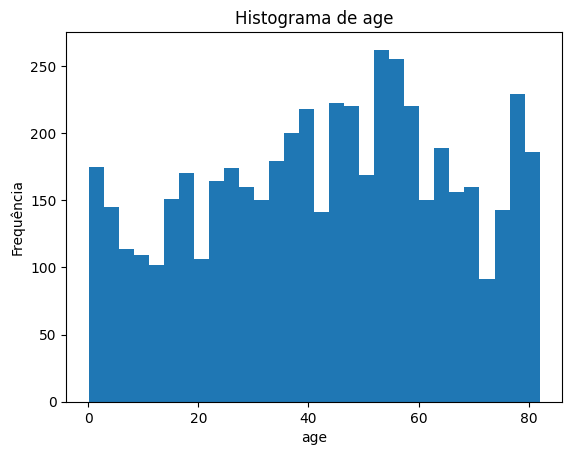

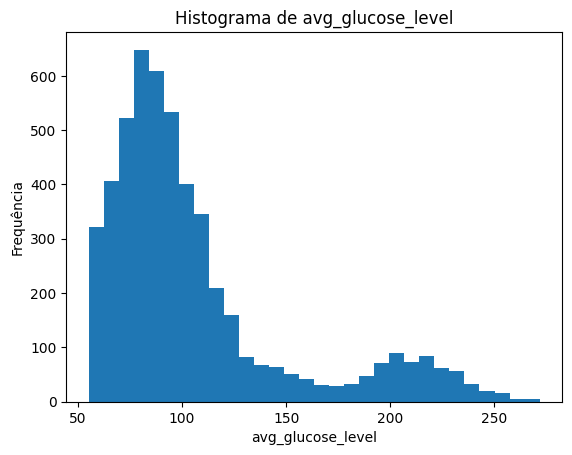

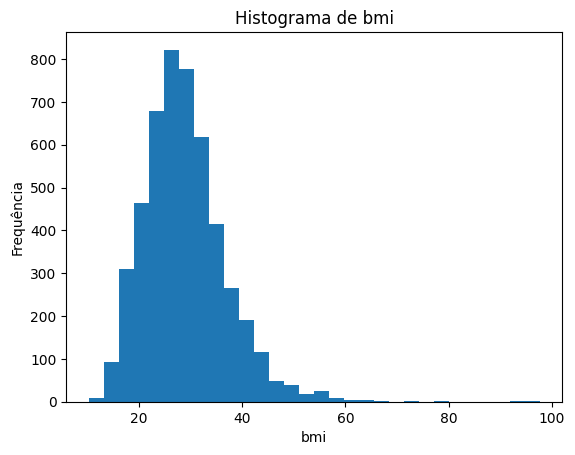

In [6]:

# Distribuições numéricas (Matplotlib)
num_cols = [c for c in ['age','avg_glucose_level','bmi'] if c in df.columns]

for c in num_cols:
    plt.figure()
    plt.hist(df[c].dropna().values, bins=30)
    plt.title(f"Histograma de {c}")
    plt.xlabel(c); plt.ylabel("Frequência")
    plt.show()


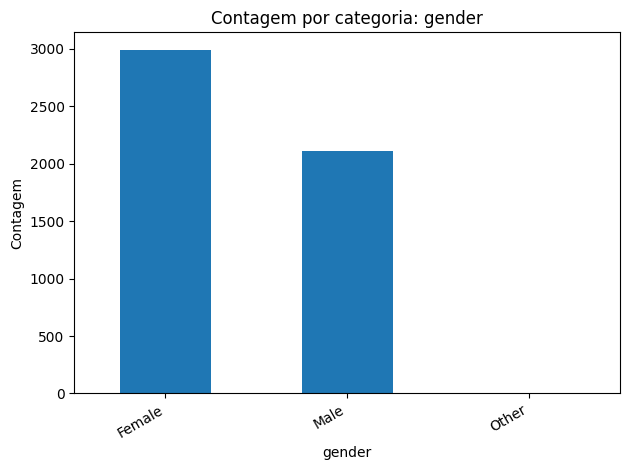

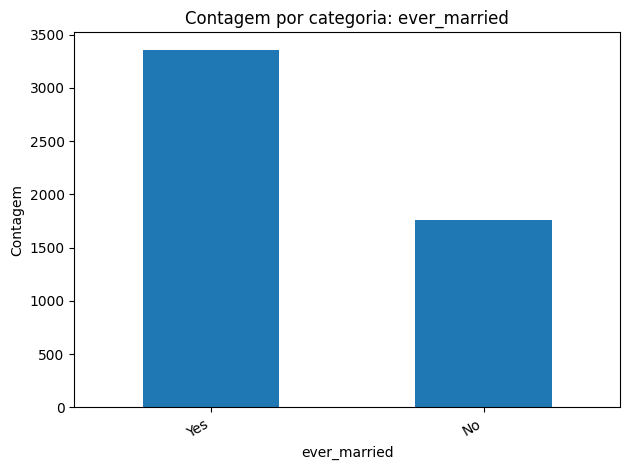

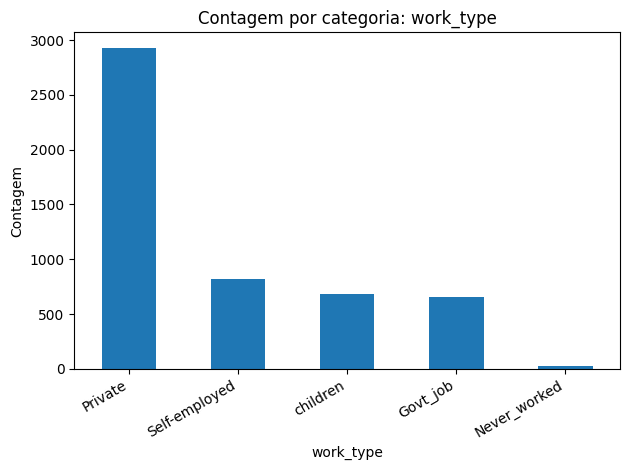

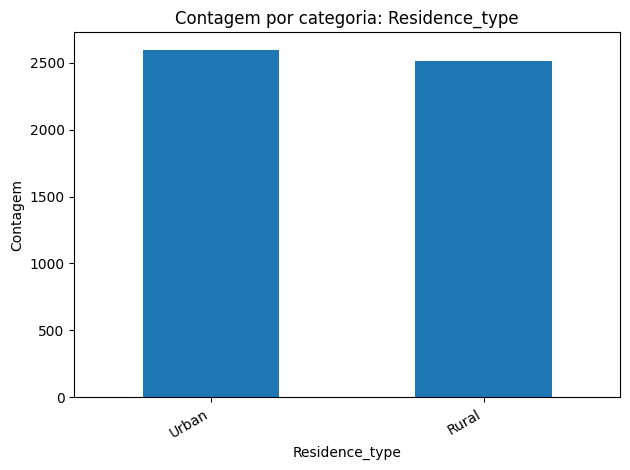

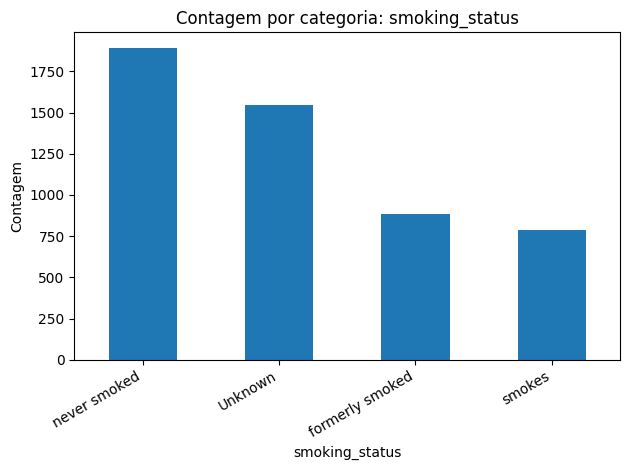

In [7]:

# Contagens categóricas
cat_cols = [c for c in ['gender','ever_married','work_type','Residence_type','smoking_status'] if c in df.columns]

for c in cat_cols:
    plt.figure()
    df[c].value_counts().plot(kind="bar")
    plt.title(f"Contagem por categoria: {c}")
    plt.xlabel(c); plt.ylabel("Contagem")
    plt.xticks(rotation=30, ha='right')
    plt.tight_layout()
    plt.show()


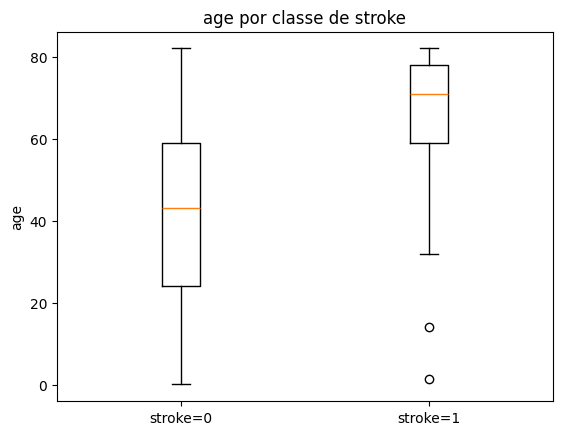

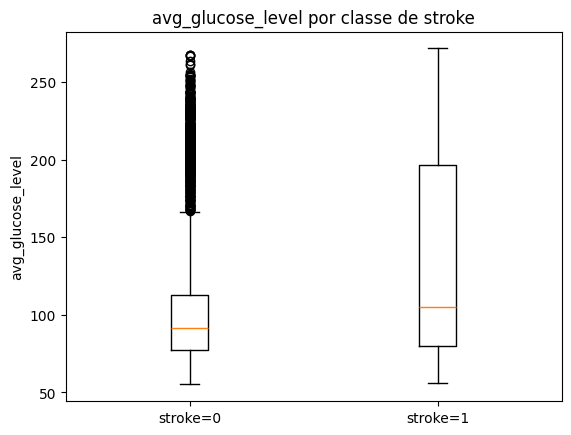

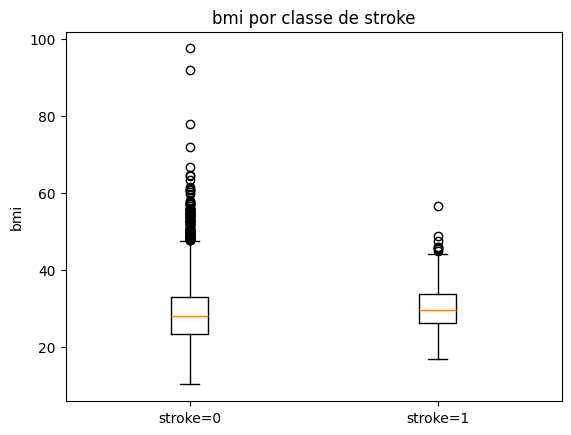

stroke,0,1
gender,,
Male,0.948936,0.051064
Female,0.952906,0.047094
Other,1.000000,0.000000


stroke,0,1
ever_married,,
Yes,0.934387,0.065613
No,0.983495,0.016505


stroke,0,1
work_type,,
Self-employed,0.920635,0.079365
Private,0.949060,0.050940
Govt_job,0.949772,0.050228
children,0.997089,0.002911
Never_worked,1.000000,0.000000


stroke,0,1
Residence_type,,
Urban,0.947997,0.052003
Rural,0.954654,0.045346


stroke,0,1
smoking_status,,
formerly smoked,0.920904,0.079096
smokes,0.946768,0.053232
never smoked,0.952431,0.047569
Unknown,0.969560,0.030440


In [9]:

# Relação com o alvo
target = 'stroke'
assert target in df.columns, "Coluna 'stroke' não encontrada no CSV."

# Boxplots para numéricos por classe do alvo
for c in num_cols:
    plt.figure()
    # Boxplot manual: dividir por classe
    data0 = df[df[target]==0][c].dropna().values
    data1 = df[df[target]==1][c].dropna().values
    plt.boxplot([data0, data1], tick_labels=['stroke=0','stroke=1'])
    plt.title(f"{c} por classe de stroke")
    plt.ylabel(c)
    plt.show()

# Tabelas de proporção para categóricas
for c in cat_cols:
    ct = pd.crosstab(df[c], df[target], normalize='index')
    display(ct.sort_values(by=1, ascending=False).head(10))


,stroke,age,avg_glucose_level,bmi,hypertension,heart_disease
stroke,1.000000,0.245257,0.131945,0.042374,0.127904,0.134914
age,0.245257,1.000000,0.238171,0.333398,0.276398,0.263796
avg_glucose_level,0.131945,0.238171,1.000000,0.175502,0.174474,0.161857
bmi,0.042374,0.333398,0.175502,1.000000,0.167811,0.041357
hypertension,0.127904,0.276398,0.174474,0.167811,1.000000,0.108306
heart_disease,0.134914,0.263796,0.161857,0.041357,0.108306,1.000000


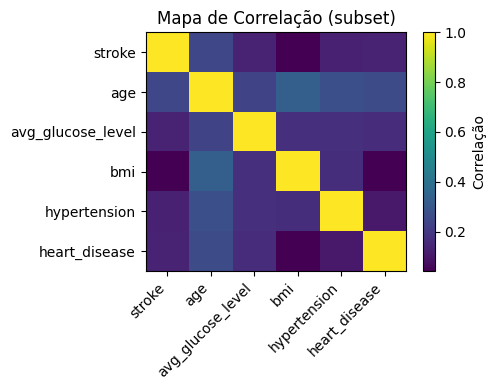

In [10]:

# Correlações principais (com variáveis binárias relevantes)
cols_corr = [col for col in ['stroke','age','avg_glucose_level','bmi','hypertension','heart_disease'] if col in df.columns]
corr = df[cols_corr].corr(numeric_only=True)
display(corr)

plt.figure(figsize=(5,4))
plt.imshow(corr, cmap='viridis', aspect='auto')
plt.colorbar(label='Correlação')
plt.xticks(range(len(cols_corr)), cols_corr, rotation=45, ha='right')
plt.yticks(range(len(cols_corr)), cols_corr)
plt.title("Mapa de Correlação (subset)")
plt.tight_layout()
plt.show()


## 5) Processamento dos Dados e Split

In [11]:

# Definição de colunas
all_cols = df.columns.tolist()
target = 'stroke'
feature_cols = [c for c in all_cols if c != target]

num_cols = [c for c in ['age','avg_glucose_level','bmi'] if c in feature_cols]
bin_cols = [c for c in ['hypertension','heart_disease'] if c in feature_cols]
cat_cols = [c for c in ['gender','ever_married','work_type','Residence_type','smoking_status']
            if c in feature_cols]

X = df[feature_cols].copy()
y = df[target].astype(int).copy()

# Splits estratificados
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=SEED
)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=SEED
)

print("Tamanhos:", X_train.shape, X_valid.shape, X_test.shape)

# Transformadores
numeric_tf = ImbPipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler',  StandardScaler())
])

# OneHotEncoder compatível com diferentes versões do sklearn
try:
    categorical_tf = ImbPipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot',  OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
except TypeError:
    categorical_tf = ImbPipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot',  OneHotEncoder(handle_unknown='ignore', sparse=False))
    ])

preprocess = ColumnTransformer(transformers=[
    ('num', numeric_tf, num_cols),
    ('cat', categorical_tf, cat_cols),
    ('passthrough', 'passthrough', bin_cols)
])

# Salvar splits (opcional)
X_train.assign(stroke=y_train.values).to_csv(PROC_PATH / "train.csv", index=False)
X_valid.assign(stroke=y_valid.values).to_csv(PROC_PATH / "valid.csv", index=False)
X_test.assign(stroke=y_test.values).to_csv(PROC_PATH / "test.csv", index=False)


Tamanhos: (3577, 10) (766, 10) (767, 10)


## 6) Modelagem — Baselines e Modelos Principais

In [12]:

def eval_model(name, model, X_tr=X_train, y_tr=y_train, X_va=X_valid, y_va=y_valid, threshold=0.5):
    model.fit(X_tr, y_tr)
    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(X_va)[:,1]
    else:
        # fallback para decision_function se disponível
        if hasattr(model, "decision_function"):
            from sklearn.preprocessing import MinMaxScaler
            scores = model.decision_function(X_va).reshape(-1,1)
            proba = MinMaxScaler().fit_transform(scores).ravel()
        else:
            # último recurso: usar previsões como "probabilidade"
            proba = model.predict(X_va).astype(float)
    preds = (proba >= threshold).astype(int)
    out = {
        "roc_auc": float(roc_auc_score(y_va, proba)),
        "pr_auc": float(average_precision_score(y_va, proba)),
        "report": classification_report(y_va, preds, digits=3, output_dict=True)
    }
    print(f"[{name}] ROC-AUC: {out['roc_auc']:.4f} | PR-AUC: {out['pr_auc']:.4f}")
    print(classification_report(y_va, preds, digits=3))
    return out, proba

# Dummy (baseline de referência)
dummy = ImbPipeline(steps=[
    ('prep', preprocess),
    ('clf', DummyClassifier(strategy='most_frequent'))
])
_ , _ = eval_model("Dummy", dummy)

# Regressão Logística com SMOTE + class_weight
logreg = ImbPipeline(steps=[
    ('prep', preprocess),
    ('smote', SMOTE(random_state=SEED)),
    ('clf', LogisticRegression(max_iter=500, class_weight='balanced', n_jobs=None))
])
log_out, log_proba = eval_model("LogReg + SMOTE", logreg)

# Random Forest (sem SMOTE; usa class_weight)
rf = ImbPipeline(steps=[
    ('prep', preprocess),
    ('clf', RandomForestClassifier(
        n_estimators=400, random_state=SEED, class_weight='balanced_subsample'
    ))
])
rf_out, rf_proba = eval_model("RandomForest", rf)


c:\Users\argus\workspace\StrokePrediction\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\argus\workspace\StrokePrediction\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\argus\workspace\StrokePrediction\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{me

[Dummy] ROC-AUC: 0.5000 | PR-AUC: 0.0483
              precision    recall  f1-score   support

           0      0.952     1.000     0.975       729
           1      0.000     0.000     0.000        37

    accuracy                          0.952       766
   macro avg      0.476     0.500     0.488       766
weighted avg      0.906     0.952     0.928       766

[LogReg + SMOTE] ROC-AUC: 0.8445 | PR-AUC: 0.3096
              precision    recall  f1-score   support

           0      0.984     0.742     0.846       729
           1      0.130     0.757     0.221        37

    accuracy                          0.743       766
   macro avg      0.557     0.749     0.534       766
weighted avg      0.942     0.743     0.816       766

[RandomForest] ROC-AUC: 0.8062 | PR-AUC: 0.1342
              precision    recall  f1-score   support

           0      0.952     0.997     0.974       729
           1      0.000     0.000     0.000        37

    accuracy                          0.949

In [13]:

# Selecionar o melhor por PR-AUC (AUC-PR é mais informativa em classes raras)
best_name, best_model, best_pr = None, None, -1.0
candidates = [("LogReg+SMOTE", logreg), ("RandomForest", rf)]
for name, mdl in candidates:
    out, _ = eval_model(name, mdl)
    if out["pr_auc"] > best_pr:
        best_name, best_model, best_pr = name, mdl, out["pr_auc"]

print(f"\nModelo base escolhido (val PR-AUC): {best_name} ({best_pr:.4f})")

# Se o escolhido for RandomForest, vamos fazer uma RandomizedSearchCV para melhorar
use_search = isinstance(best_model.named_steps.get('clf'), RandomForestClassifier)

if use_search:
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    param_rf = {
        'clf__n_estimators': randint(200, 700),
        'clf__max_depth': randint(3, 18),
        'clf__min_samples_split': randint(2, 20)
    }
    rf_cv = ImbPipeline(steps=[('prep', preprocess),
                               ('clf', RandomForestClassifier(random_state=SEED, class_weight='balanced_subsample'))])

    search = RandomizedSearchCV(
        rf_cv, param_rf, n_iter=25, scoring='average_precision', cv=cv, n_jobs=-1, random_state=SEED, verbose=1
    )
    search.fit(X_train, y_train)
    best_model = search.best_estimator_
    print("Melhores hiperparâmetros:", search.best_params_)
else:
    print("Mantendo o modelo LogReg+SMOTE como campeão base.")


[LogReg+SMOTE] ROC-AUC: 0.8445 | PR-AUC: 0.3096
              precision    recall  f1-score   support

           0      0.984     0.742     0.846       729
           1      0.130     0.757     0.221        37

    accuracy                          0.743       766
   macro avg      0.557     0.749     0.534       766
weighted avg      0.942     0.743     0.816       766

[RandomForest] ROC-AUC: 0.8062 | PR-AUC: 0.1342
              precision    recall  f1-score   support

           0      0.952     0.997     0.974       729
           1      0.000     0.000     0.000        37

    accuracy                          0.949       766
   macro avg      0.476     0.499     0.487       766
weighted avg      0.906     0.949     0.927       766


Modelo base escolhido (val PR-AUC): LogReg+SMOTE (0.3096)
Mantendo o modelo LogReg+SMOTE como campeão base.


### 6.1 Otimização de Threshold (decisão)

In [14]:

# Escolher limiar que maximize F1 na validação (ou garanta recall mínimo)
proba_valid = best_model.predict_proba(X_valid)[:,1]
prec, rec, thr = precision_recall_curve(y_valid, proba_valid)

# Estratégia 1: threshold que maximiza F1
f1 = (2 * prec * rec) / (prec + rec + 1e-12)
best_idx = np.nanargmax(f1)
best_thr_f1 = thr[best_idx-1] if best_idx > 0 and best_idx-1 < len(thr) else 0.5

# Estratégia 2: recall mínimo de 0.60 + maior precisão possível
mask = rec >= 0.60
best_thr_recall = thr[mask][np.argmax(prec[mask])] if np.any(mask) else best_thr_f1

best_thr = float(best_thr_recall)
print("Threshold (F1):", round(float(best_thr_f1), 4))
print("Threshold (rec>=0.60):", round(float(best_thr_recall), 4))
print("Threshold escolhido:", round(best_thr, 4))


IndexError: boolean index did not match indexed array along axis 0; size of axis is 766 but size of corresponding boolean axis is 767

### 6.2 Interpretabilidade — Importâncias (árvore/permutação)

In [15]:

# Importância por permutação no conjunto de validação
result = permutation_importance(best_model, X_valid, y_valid, n_repeats=10, random_state=SEED)
# Tentar recuperar nomes das features do preprocessador
try:
    prep = best_model.named_steps['prep']
    # pegar OneHotEncoder para extrair nomes das categorias
    onehot = prep.named_transformers_['cat'].named_steps['onehot']
    ohe_names = list(onehot.get_feature_names_out(prep.transformers_[1][2]))  # cat_cols
    feat_names = list(prep.transformers_[0][2]) + ohe_names + list(prep.transformers_[2][2])  # num + ohe + bin
except Exception as e:
    # fallback: índices
    feat_names = [f"feat_{i}" for i in range(len(result.importances_mean))]

imp_series = pd.Series(result.importances_mean, index=feat_names).sort_values(ascending=False)
display(imp_series.head(15))

plt.figure(figsize=(8,5))
imp_series.head(15).iloc[::-1].plot(kind="barh")
plt.title("Top 15 - Importância por permutação")
plt.tight_layout()
plt.show()


ValueError: Length of values (10) does not match length of index (21)

## 7) Avaliação Final no Conjunto de Teste

In [16]:

def evaluate_on_test(model, X_te=X_test, y_te=y_test, threshold=0.5):
    proba = model.predict_proba(X_te)[:,1]
    preds = (proba >= threshold).astype(int)
    print("ROC-AUC:", roc_auc_score(y_te, proba).round(4))
    print("PR-AUC :", average_precision_score(y_te, proba).round(4))
    print(classification_report(y_te, preds, digits=3))

    cm = confusion_matrix(y_te, preds)
    ConfusionMatrixDisplay(cm).plot()
    plt.title("Matriz de Confusão (Teste)")
    plt.show()

evaluate_on_test(best_model, threshold=best_thr)

# Métricas por subgrupos simples (fairness exploratório)
for grp in [c for c in ['gender','Residence_type'] if c in X_test.columns]:
    print(f"\n== Métricas por grupo: {grp} ==")
    for v in X_test[grp].dropna().unique():
        mask = (X_test[grp] == v).values
        if mask.sum() < 2:  # evitar relatórios com 1 amostra
            continue
        proba_g = best_model.predict_proba(X_test[mask])[:,1]
        preds_g = (proba_g >= best_thr).astype(int)
        print(f"\nGrupo = {grp} == {v}  (n={mask.sum()})")
        print(classification_report(y_test[mask], preds_g, digits=3))


NameError: name 'best_thr' is not defined

## 8) Persistência de Artefatos e Inferência

In [17]:

# Salvar modelo e metadados
MODELS_PATH.mkdir(exist_ok=True, parents=True)
model_path = MODELS_PATH / "stroke_model.joblib"
meta_path  = MODELS_PATH / "artifact.json"

joblib.dump(best_model, model_path)
artifact = {
    "model_path": str(model_path),
    "threshold": float(best_thr),
    "created_at_utc": datetime.utcnow().isoformat(),
    "features": X.columns.tolist()
}
with open(meta_path, "w") as f:
    json.dump(artifact, f, indent=2)

print("Modelo salvo em:", model_path)
print("Metadados salvos em:", meta_path)


NameError: name 'best_thr' is not defined

In [ ]:

# Função de inferência (exemplo)
def predict_stroke(input_row: dict, model=None, threshold=None):
    if model is None:
        model = joblib.load("models/stroke_model.joblib")
    if threshold is None:
        meta = json.load(open("models/artifact.json"))
        threshold = float(meta.get("threshold", 0.5))
        feat = meta.get("features")
        # garantir colunas na ordem
        row_df = pd.DataFrame([input_row])[feat]
    else:
        row_df = pd.DataFrame([input_row])[X.columns]
    proba = model.predict_proba(row_df)[:,1][0]
    pred  = int(proba >= threshold)
    return {"probability": float(proba), "prediction": pred, "threshold": float(threshold)}

# Exemplo (ajuste os valores conforme necessário):
example = {
    "gender":"Male","age":67,"hypertension":1,"heart_disease":1,"ever_married":"Yes",
    "work_type":"Private","Residence_type":"Urban","avg_glucose_level":205.0,"bmi":27.5,"smoking_status":"formerly smoked"
}
predict_stroke(example, model=best_model, threshold=best_thr)


### 8.1 API FastAPI (Opcional)

In [ ]:

# Para usar: salve este conteúdo como fastapi_app.py e rode: uvicorn fastapi_app:app --reload
FASTAPI_TEMPLATE = r'''
from fastapi import FastAPI
import joblib, json, pandas as pd

app = FastAPI(title="Stroke Prediction API", version="1.0.0")

MODEL_PATH = "models/stroke_model.joblib"
META_PATH  = "models/artifact.json"

model = joblib.load(MODEL_PATH)
meta  = json.load(open(META_PATH))
threshold = float(meta.get("threshold", 0.5))
features  = meta.get("features")

@app.get("/health")
def health():
    return {"status":"ok"}

@app.post("/predict")
def predict(payload: dict):
    import pandas as pd
    x = pd.DataFrame([payload])[features]
    proba = model.predict_proba(x)[:,1][0]
    pred  = int(proba >= threshold)
    return {"probability": float(proba), "prediction": pred, "threshold": threshold}
'''
print(FASTAPI_TEMPLATE)



## 9) Próximos Passos

- Experimentar *class_weight* e SMOTE em diferentes modelos, comparando **AUC-PR**.  
- Calibração de probabilidades (*Platt* / *Isotonic*).  
- Análise de *feature importance* por subgrupos para investigar vieses.  
- Registrar experimentos (ex.: MLflow) e versionar dados/modelos.  
- Protótipo de **deploy**: FastAPI/Gradio, ou exportar previsões para um dashboard (BI).
